# Expectation-maximization algorithm

In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

### Installation

We will need ```numpy```, ```scikit-learn```, ```matplotlib``` libraries for this assignment

In [14]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submitting function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [2]:
grader = Grader()

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

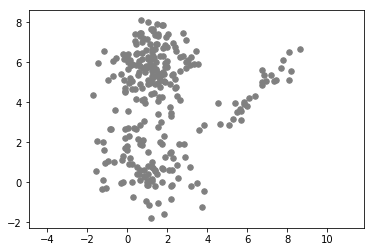

In [3]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [4]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    ### YOUR CODE HERE
    for s_id in range(N):
        for c in range(C):
            #Compute normal densities with log-sum-exp trick
            gamma[s_id,c] = compute_gamma_exp(x=X[s_id,:],mu=mu[c,:],sigma=sigma[c,:,:],pi=pi[c])
        max_elem = np.amax(gamma[s_id,:])
        gamma[s_id,:] = np.subtract(gamma[s_id,:],max_elem)
        gamma[s_id,:] = np.exp(gamma[s_id,:])
        gamma[s_id,:] = np.divide(gamma[s_id,:],np.sum(gamma[s_id,:]))
            
    return gamma

def compute_gamma_exp(x,mu,sigma,pi):
    """
    Compute exponenent used in gamma calc
    x : d-dimensional data point
    mu : d-dimensional mean
    sigma : (d,d) dimensional covaraiance matrix
    
    Returns: 
        exp(num - log(denom) + log(pi))
        num : Numerator of MV gaussian
        denom : Denom of MV gaussian
    
    """
    dim = mu.shape[0]
    diff = x-mu
    sigma_inv = np.linalg.solve(sigma,np.identity(dim))
    num = np.dot(diff.T,sigma_inv)
    num = np.dot(num,diff)
    num = -0.5*num
    sigma_det = np.linalg.det(sigma)
    denom = np.sqrt(np.power((2*np.pi),dim)*sigma_det)
    exp = num - np.log(denom) + np.log(pi)
    return exp

In [5]:
gamma = E_step(X, pi0, mu0, sigma0)
grader.submit_e_step(gamma)

Current answer for task Task 1 (E-step) is: 0.5337178741081262


### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [6]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    mu = np.zeros((C,d))
    sigma = np.zeros((C,d,d))
    pi = np.zeros((C))
    
    # Calculate mu
    for c in range(C):
        for idx in range(N):
            mu[c,:] += np.multiply(gamma[idx,c],X[idx,:])
        mu[c,:] = np.divide(mu[c,:],np.sum(gamma[:,c]))
    
    # Calculate sigma
    for c in range(C):
        for idx in range(N):
            sigma[c,:,:] += np.outer((X[idx,:] - mu[c,:]),(X[idx,:]-mu[c,:]))*gamma[idx,c]
        sigma[c,:,:] = np.divide(sigma[c,:,:],np.sum(gamma[:,c]))
    
    # Calculate pi
    for c in range(C):
        pi[c] = np.divide(np.sum(gamma[:,c]),N)

    return pi, mu, sigma

In [7]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
grader.submit_m_step(pi, mu, sigma)

Current answer for task Task 2 (M-step: mu) is: 2.8993918820503835
Current answer for task Task 2 (M-step: sigma) is: 5.9771052168975265
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218775


### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [10]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    # Code not optimized for performance -- focus on readability 
    
    loss_part_1 = 0
    ### YOUR CODE HERE
    for idx in range(N):
        inner_sum = 0
        for c in range(C):
            inner_sum += gamma[idx,c]*compute_gamma_exp(x=X[idx,:],mu=mu[c,:],sigma=sigma[c,:,:],pi=pi[c])
        loss_part_1 += inner_sum
    
    loss_part_2 = 0
    for idx in range(N):
        inner_sum = 0
        for c in range(C):
            inner_sum += gamma[idx,c]*np.log(gamma[idx,c])
        loss_part_2 += inner_sum
        
    loss = loss_part_1 - loss_part_2
            

    return loss



In [11]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
grader.submit_VLB(loss)

Current answer for task Task 3 (VLB) is: -1213.973464306019


### Bringing it all together

Now that we have E step, M step and VLB, we can implement training loop. We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

<b>Task 4:</b> Implement training procedure

In [41]:
from sklearn.datasets import make_spd_matrix
import random

def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            # Initialize
            mu,sigma,pi = init(X,C)
            gamma = E_step(X, pi, mu, sigma)
            pi, mu, sigma = M_step(X, gamma)
            loss = compute_vlb(X, pi, mu, sigma, gamma)
            print('Restart : {} Loss : {}'.format(_,loss))
            for iteration in range(max_iter):
                prev_loss = loss
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                print('Restart : {} Iter : {} Loss : {}'.format(_,iteration,loss))
                stop_condition = abs((loss-prev_loss)/prev_loss)
                if stop_condition <= rtol:
                    break
            if best_loss is None:
                best_loss = loss
            else:
                if loss > best_loss: #Update best loss (we are maximizing the VLB!)
                    best_loss = loss
                    best_mu = mu
                    best_pi = pi
                    best_sigma = sigma
                    
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass
        
    return best_loss, best_pi, best_mu, best_sigma

def init(X,C):
    """
    Function to initialize GMM parameters
    Input: C number of clusters
    Returns: mu,sigma,pi
    """
    # For mu, randonly sample C points from X
    indices = np.random.choice(X.shape[0],size=(C,))
    mu = X[indices]
    
    #For sigma, use sklearn API to sample psd matrices for all clusters
    sigma = np.asarray([make_spd_matrix(X.shape[1]) for c in range(C)])
    
    # Sample pi such they all sum to 1
    pi = []
    acc = 0
    for c in range(C):
        pi.append(random.random())
    pi = np.asarray(pi)
    pi = np.divide(pi,np.sum(pi))
    
    return mu,sigma,pi

        

In [42]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
grader.submit_EM(best_loss)

Restart : 0 Loss : -1188.5484413891331
Restart : 0 Iter : 0 Loss : -1176.4089677408153
Restart : 0 Iter : 1 Loss : -1172.7986530597575
Restart : 0 Iter : 2 Loss : -1169.2572380858592
Restart : 0 Iter : 3 Loss : -1165.5496437545366
Restart : 0 Iter : 4 Loss : -1162.3711217297914
Restart : 0 Iter : 5 Loss : -1160.5507987120543
Restart : 0 Iter : 6 Loss : -1159.7821772833165
Restart : 1 Loss : -1118.5442816308498
Restart : 1 Iter : 0 Loss : -1091.4339057539341
Restart : 1 Iter : 1 Loss : -1075.9456275102855
Restart : 1 Iter : 2 Loss : -1067.294425649624
Restart : 1 Iter : 3 Loss : -1065.7690196279402
Restart : 1 Iter : 4 Loss : -1064.8826232674735
Restart : 2 Loss : -1166.7270544378198
Restart : 2 Iter : 0 Loss : -1144.0463922087818
Restart : 2 Iter : 1 Loss : -1135.5411946362
Restart : 2 Iter : 2 Loss : -1129.763007974418
Restart : 2 Iter : 3 Loss : -1124.9007804114399
Restart : 2 Iter : 4 Loss : -1120.4452449176754
Restart : 2 Iter : 5 Loss : -1116.3594001137221
Restart : 2 Iter : 6 Los

If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


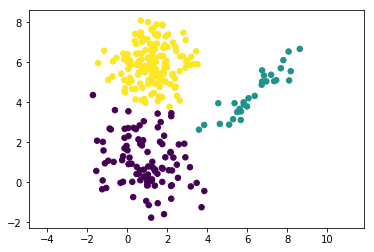

In [43]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and your token into variables below. You can generate the token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

If you want to submit these answers, run cell below

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)